# autocompcam

Goal: build a camera that can detect if a shot is well framed, helping non-photographers think like photographers and take better pictures<br>
Ideally this would work in real time, but first I'm going to try to get it to work one frame at a time.<br>
Based off of some of this paper: https://dl.acm.org/doi/epdf/10.1145/2647868.2654979

### copied from dataset readme:

The mat file "500_image_dataset.mat" contains a list of 500 images and the corresponding bounding boxes collected on Amazon Mechnical Turk.<br>
The bbox field contains the four corners of bounding box in the order of (height_min, width_min, height_max, width_max).<br>
So, if you have an 3 channel RGB image "im" to crop, this Matlab code will do the job: im(height_min:height_max, width_min:width_max, :).<br>
For some reasons, turkers may fail to provid valid bounding boxes, in these cases, you may get negative coordinates, simply ignore them.<br>
0 value means the first pixel, simply treat them as 1 if using in Matlab.

In [1]:
import math
import time
from joblib import dump, load

from scipy.io import loadmat

import pandas as pd

from matplotlib import pyplot as plt
import cv2

import numpy as np

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [2]:
#load matlab from file
allFrames = loadmat('release_data/500_image_dataset.mat')

#place into pandas dataframe
data = [[line['filename'][0][0], line['bbox'][0]] for line in allFrames['img_gt']]

columns = ['filename', 'bbox']
train = pd.DataFrame(data, columns=columns)

train

#TODO: clear all bboxs with -1,-1,-1,-1 to make them easier to ignore. 

,filename,bbox
0,1010203631_Large.jpg,"[[276, 124, 539, 1024], [204, 8, 636, 1024], [..."
1,1011366896_Large.jpg,"[[19, 161, 690, 856], [0, 0, 768, 756], [0, 10..."
2,101685710_Large.jpg,"[[109, 122, 1024, 624], [30, 0, 926, 672], [0,..."
3,1022974255_Large.jpg,"[[88, 108, 712, 940], [0, 16, 596, 810], [51, ..."
4,1029965466_Large.jpg,"[[246, 0, 824, 768], [35, 149, 861, 768], [0, ..."
...,...,...
495,997626761_Large.jpg,"[[101, 157, 933, 647], [76, 0, 919, 632], [258..."
496,IMG_0350.jpg,"[[121, 190, 743, 1123], [156, 0, 725, 854], [1..."
497,IMG_0965.jpg,"[[153, 0, 832, 1020], [266, 0, 770, 890], [106..."
498,IMG_2358.jpg,"[[124, 58, 853, 831], [99, 0, 751, 978], [168,..."


## load an image and it's associated crops to show how the dataset works

For our 'positive' set of well-composed images, we'll use the known good crops of an image generated by this dataset

In [2]:
#show all crops for first line in dataframe
fName = train.iloc[250]['filename']

img = cv2.imread('release_data/uncropped/' + fName, cv2.IMREAD_COLOR)

for i, crop in enumerate(train.iloc[0]['bbox']):
    if crop[0] != -1: #bodge until we do some data cleaning...
        fin = img[crop[0]:crop[2], crop[1]:crop[3], :]

        gray = cv2.cvtColor(fin, cv2.COLOR_BGR2RGB)

        plt.imshow(gray, interpolation="bicubic")
        plt.title('Example 1, crop ' + str(i+1))
        plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Saliency Maps

Saliency is great because it is a good metaphor and method to describe the 'most important' parts of an image. This models how humans see, too, because we rarely just look at everything at once, but only focus on a few things at a time. <br>
<br>
The code this paper uses to classify well composed crops relies on saliency maps to reduce image dimensionality. Because they used Matlab, they also were able to draw on the work of some Israeli scientists who developed a really efficient saliency map algorithm. Sadly, the code they provided was an encrypted Matlab class, and was sufficiently complex that recreating that code (and makeing it run fast, possibly with OpenCL kernals) could probably be a whole different project. <br>
<br>
We'll settle for OpenCV's own static saliency map methods, Spectral Residual saliency and Fine Grained. Spectral Residual is a little bit faster, and because I want my stuff to work in real time, I'll use that. I did try running the model with fine grained enabled as well, and didn't see a huge improvement. 

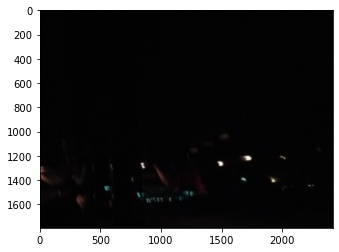

--- 0.01728534698486328 seconds ---


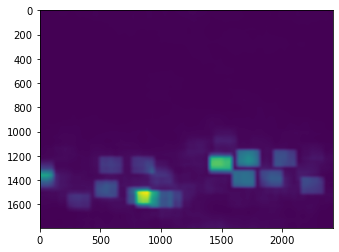

--- 0.886296272277832 seconds ---


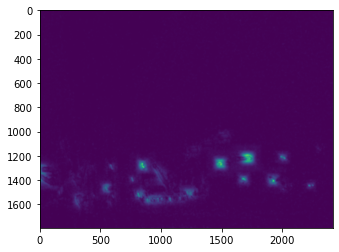

In [60]:
#load image
fName = train.iloc[1]['filename']
image = cv2.imread("shite.jpg", cv2.IMREAD_COLOR)

#show original image
original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(original, interpolation="bicubic")
plt.show()

#calculate messy saliency map
start_messy = time.time()
#StaticSaliencySpectralResidual_create()
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
simpleSaliencyMap = (saliencyMap * 255).astype("uint8")
print("--- %s seconds ---" % (time.time() - start_messy))

plt.imshow(simpleSaliencyMap, interpolation="bicubic")
plt.show()

#calculate cplx saliency map
start_cplx = time.time()
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(image)
saliencyMap = (saliencyMap * 255).astype("uint8")
print("--- %s seconds ---" % (time.time() - start_cplx))

plt.imshow(saliencyMap, interpolation="bicubic")
plt.show()

The other thing that made this paper so unique was how they described images as a spatial pyramid. I won't go into huge detail, but it basically encodes image composition in a small amount of dimensions without the need for CNNs. The code below just describes how the pyramid breaks up the saliency map into a set of histograms.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


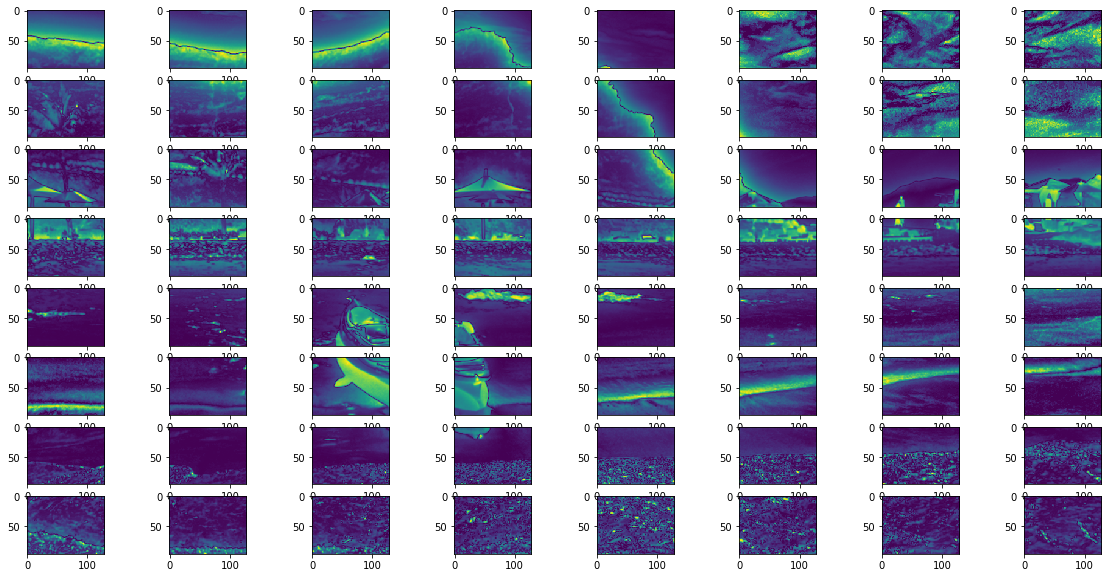

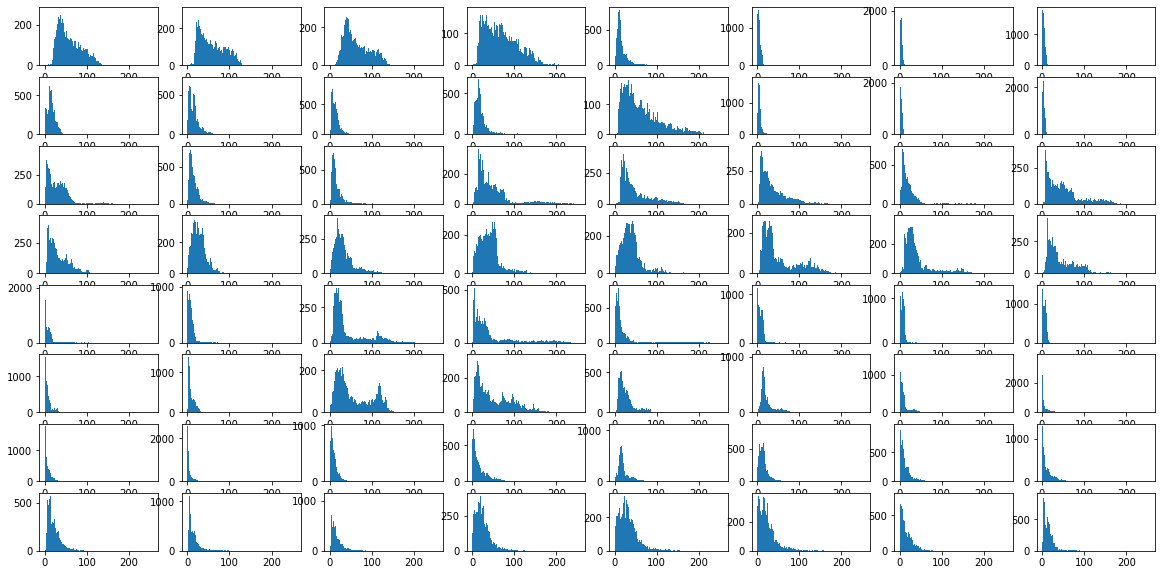

In [7]:
#splits image into M by N pixels
def gridSplit(im, M, N):
    return [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
    
#find out what we gotta split it into...
height, width = saliencyMap.shape[:2]

#set below to 8 to return 8x8 grid
nSplit = 8

#now split saliency map into 8x8 spatial grid
sGrid = gridSplit(saliencyMap, int(height/8), int(width/8))
sGrid = np.array(sGrid)
#at some point need to reshape from 64 x x to 8 8 x x 

#show the ugly divided map
fig, axes = plt.subplots(nrows=nSplit,ncols=nSplit,figsize=(20, 10))

wrapCounter = 0
for i in range(nSplit):
    for j in range(nSplit):
        axes[i,j].imshow(sGrid[wrapCounter + j])
    wrapCounter += nSplit
        
fig.show()

#show histogram rep.
fig, axes = plt.subplots(nrows=nSplit,ncols=nSplit,figsize=(20, 10))

wrapCounter = 0
for i in range(nSplit):
    for j in range(nSplit):
        axes[i,j].hist(sGrid[wrapCounter + j].ravel(), 256, [0,256])
    wrapCounter += nSplit
        
fig.show()

## preprocessing

The code below just handles preprocessing for the dataset by making a saliency map for each image, cropping it for the 'well composed' samples, taking random crops for the poorly composed samples, and unrolling each crop into the SPSM described in the paper. 

In [5]:
"""
place all of the above into a single function to do all the preprocessing at once
"""
def gridSplit(im, M, N):
    return [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

#take random crop of image
def randomCrop(img):    
    while True:
        max_x = img.shape[1]
        max_y = img.shape[0]

        rw = np.random.randint(10, max_x)
        rh = np.random.randint(10, max_y)

        rx = np.random.randint(0, max_x - rw)
        ry = np.random.randint(0, max_y - rh)

        image = img[rx:rw+rx, ry:rh+ry]
    
        if image.shape[0] > 10 and image.shape[1] > 10:
            return image

def histogram2(ssm):
    #find height and width
    height = ssm.shape[0]
    width = ssm.shape[1]
    
    #level 0
    hist = list(np.bincount(ssm.ravel(),minlength=256))
    
    #level 1
    sGrid = gridSplit(ssm, math.ceil(height/2), math.ceil(width/2))
    histograms = [list(np.bincount(sub.ravel(),minlength=256)) for sub in sGrid]
    final = []
    for idx, itm in enumerate(histograms[0]):
        for arr in histograms:
            final.append(arr[idx])
    hist.extend(final)
    
    #level 2
    sGrid = gridSplit(ssm, math.ceil(height/4), math.ceil(width/4))
    histograms = [list(np.bincount(sub.ravel(),minlength=256)) for sub in sGrid]
    final = []
    for idx, itm in enumerate(histograms[0]):
        for arr in histograms:
            final.append(arr[idx])
    hist.extend(final)

    return np.array(hist)
    

#TODO: add progress bar
def preprocess_all():  
    allCrops = []
    allBadCrops = []
    
    for index, row in train.iterrows():
        #print(str(index) + "/500")
        
        #open target image
        fName = row.filename 
        img = cv2.imread('release_data/uncropped/' + fName, cv2.IMREAD_COLOR)
        
        #find saliency map!
        saliency = cv2.saliency.StaticSaliencySpectralResidual_create() 
        #saliency = cv2.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(img)
        ssm = (saliencyMap * 255).astype("uint8")
        
        for i, crop in enumerate(row.bbox):
            if crop[0] != -1:
                image = ssm[crop[0]:crop[2], crop[1]:crop[3]] #crop image
                
                if image.shape[0] != 0 and image.shape[1] != 0:
                    #add to output array
                    allCrops.append(histogram2(image))

                    #make bad crop
                    badCrop = randomCrop(ssm)

                    #add to bad output array
                    allBadCrops.append(histogram2(badCrop))
                    
    return allCrops, allBadCrops

def preprocess_all_singleCrop():  
    allCrops = []
    allBadCrops = []
    
    for index, row in train.iterrows():
        #print(str(index) + "/500")
        
        #open target image
        fName = row.filename 
        img = cv2.imread('release_data/uncropped/' + fName, cv2.IMREAD_COLOR)
        
        #find saliency map!
        saliency = cv2.saliency.StaticSaliencySpectralResidual_create() 
        #saliency = cv2.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(img)
        ssm = (saliencyMap * 255).astype("uint8")
        
        #make bad crop
        badCrop = randomCrop(ssm)
        
        allBadCrops.append(histogram2(badCrop))
        allCrops.append(histogram2(ssm))
        
                    
    return allCrops, allBadCrops

The code below actually runs the preprocessor and generates labels.

In [6]:
#generate postive and negative input values
x_good, x_bad = preprocess_all()

#generate 'correct' and incorrect class labels
y_good = np.ones(len(x_good))
y_bad = np.zeros(len(x_bad))

X, y = shuffle(x_good + x_bad, np.append(y_good, y_bad), random_state=0)

Next, use an SVR to fit an association between the SPSMs and labels! This will take a little bit, beware. Also, the paper didn't mention it but I'm using a scalar transform and PCA to normalize the matrix values and prevent overfitting. You could also try SVR here, it's up to you. 

In [7]:
ss = StandardScaler()
# run this on our feature matrix
xt = ss.fit_transform(X)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
x_pca = pca.fit_transform(xt)

#regr = SVC(kernel='linear', probability=True, random_state=42, verbose=1)

regr = SVR(C=1.0)

regr.fit(x_pca, y)

regr.score(x_pca, y, sample_weight=None)

0.832474992488056

In [6]:
dump(regr, 'compCam.joblib') 
dump(ss, 'ssModel.joblib')
dump(pca, 'pcaMode.joblib')

['pcaMode.joblib']

In [2]:
regr = load('compCam.joblib') 
ss = load('ssModel.joblib')
pca = load('pcaMode.joblib')

## testing
Next, test on some sample photos, both from the collection of stuff I've takn as well as the actual dataset. Note the difference here isn't huge, and the model accuracy wasn't great (even without splitting test/training datasets). I will discuss more later. 

In [3]:
def pipeline(fName):
    #load
    img = cv2.imread(fName, cv2.IMREAD_COLOR)
    
    #saliency
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create() 
    #saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(img)
    ssm = (saliencyMap * 255).astype("uint8")
    
    #histogram
    hist = histogram2(ssm)
    rhist = hist.reshape(1, -1)
    
    display(rh)
    
    #ss and pca
    rhist = ss.transform(rhist)
    rhist = pca.transform(rhist)

    return rhist

def showi(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(original, interpolation="bicubic")
    plt.show()
    return

def pipeline_helper(img_path):
    test_img = pipeline(img_path)
    guess = regr.predict(test_img)
    display("composition score: " + str(guess[0]))
    showi(img_path)
    return

'composition score: 0.9001866835619419'

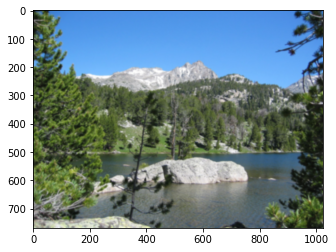

'composition score: 0.7024757590463978'

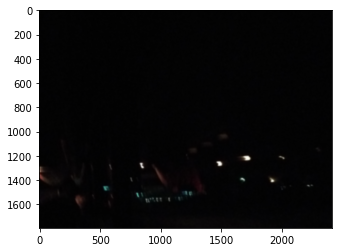

'composition score: 0.7024757590463978'

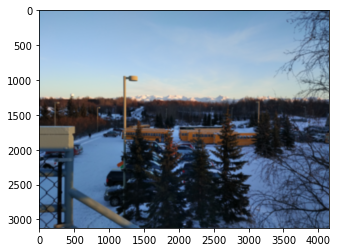

'composition score: 0.7041956534031006'

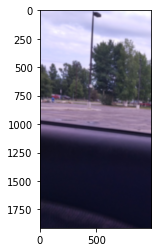

'composition score: 0.7024757590464016'

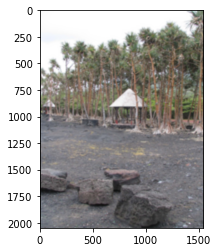

In [6]:
pipeline_helper("release_data/uncropped/346203306_Large.jpg")
pipeline_helper("shite.jpg")
pipeline_helper("good.jpg")
pipeline_helper("bad.jpg")
pipeline_helper("release_data/uncropped/104902.jpg")

## Now, let's deploy the model on a live feed!

Try desktop script :)